In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, recall_score, precision_score, mean_absolute_error, f1_score, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/my drive/Battery_dataset.csv" "/content/"


In [ ]:
df1 = pd.read_csv('Battery_dataset.csv')

In [ ]:
df1.head(7)

,battery_id,cycle,chI,chV,chT,disI,disV,disT,BCt,SOH,RUL
0,B5,1,1.440147,4.254682,23.988733,1.894407,3.273523,32.980834,1.986196,99.309790,219
1,B5,2,1.416595,4.159825,25.665347,1.829949,4.038741,32.257920,1.986240,99.311985,218
2,B5,3,1.420272,4.276323,25.407910,1.942105,3.214433,35.134801,1.984252,99.212608,217
3,B5,4,1.337680,4.236697,27.069757,2.073577,3.134529,32.082988,1.969236,98.461812,216
4,B5,5,1.263946,4.142791,26.478353,2.049885,3.729341,32.483154,1.974862,98.743106,215
5,B5,6,1.509148,4.146696,26.483647,2.046433,2.973916,35.172359,1.976299,98.814946,214
6,B5,7,1.374813,4.222430,25.977104,1.970787,3.549099,33.230227,1.965698,98.284885,213


In [ ]:
df1.shape

(680, 11)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   battery_id  680 non-null    object 
 1   cycle       680 non-null    int64  
 2   chI         680 non-null    float64
 3   chV         680 non-null    float64
 4   chT         680 non-null    float64
 5   disI        680 non-null    float64
 6   disV        680 non-null    float64
 7   disT        680 non-null    float64
 8   BCt         680 non-null    float64
 9   SOH         680 non-null    float64
 10  RUL         680 non-null    int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 58.6+ KB


In [ ]:
# Checking for missing values
df1.isna().sum()

,0
battery_id,0
cycle,0
chI,0
chV,0
chT,0
disI,0
disV,0
disT,0
BCt,0
SOH,0


In [ ]:
# Checking for duplicated values
df1.duplicated().sum()

np.int64(0)

In [ ]:
# figuring out the types of battery used in this dataset
df1['battery_id'].unique()

array(['B5', 'B6', 'B7'], dtype=object)

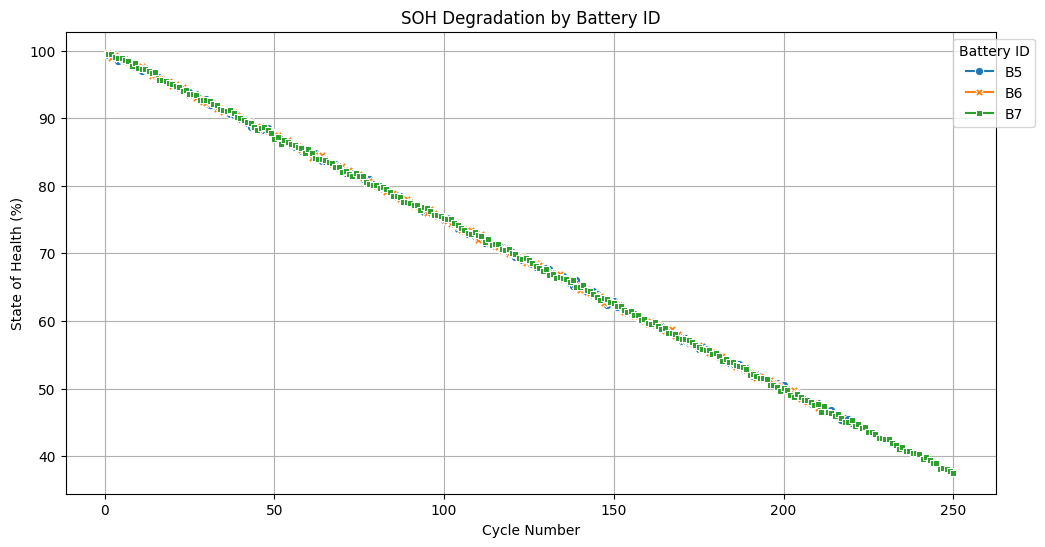

In [ ]:
# We need to observe trends and make deductions
# Firstly we visualize the trends

# We plot SOH degradation for each battery
plt.figure(figsize=(12, 6))

sns.lineplot(x="cycle", y="SOH", hue="battery_id", data=df1, style="battery_id", markers=True, dashes=False)
plt.title("SOH Degradation by Battery ID")
plt.xlabel("Cycle Number")
plt.ylabel("State of Health (%)")
plt.legend(title="Battery ID", bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

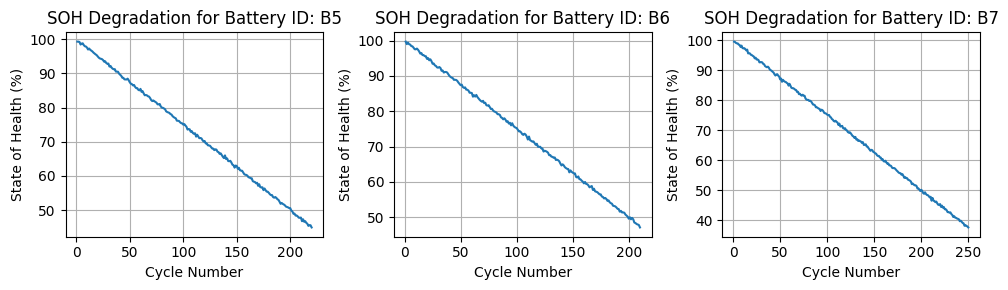

In [ ]:
# Plotting each battery's SOH trend in a separate subplot to visualize the data clearly
battery_ids = df1['battery_id'].unique()
plt.figure(figsize=(10, 3))

for i, battery_id in enumerate(battery_ids):
  plt.subplot(1, 3, i + 1)
  battery_data = df1[df1['battery_id'] == battery_id]
  sns.lineplot(x="cycle", y="SOH", data=battery_data)
  plt.title(f"SOH Degradation for Battery ID: {battery_id}")
  plt.xlabel("Cycle Number")
  plt.ylabel("State of Health (%)")
  plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# The data shows a strong linearity between the cycles and state of health
# This clarifies a constant deduction rate, hence degradation is strongly predictable, and probably a strong healthy life
# A linear model is strongly recommended.

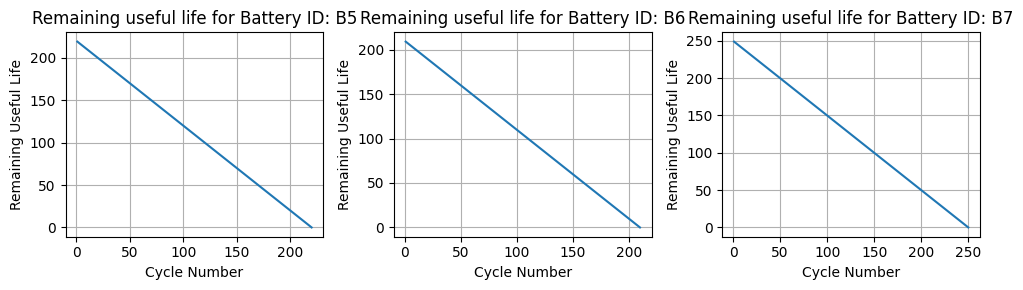

In [ ]:
# Lets now observe the trends with remaining useful lives
battery_ids = df1['battery_id'].unique()
plt.figure(figsize=(10, 3))

for i, battery_id in enumerate(battery_ids):
  plt.subplot(1, 3, i + 1)
  battery_data = df1[df1['battery_id'] == battery_id]
  sns.lineplot(x="cycle", y="RUL", data=battery_data)
  plt.title(f"Remaining useful life for Battery ID: {battery_id}")
  plt.xlabel("Cycle Number")
  plt.ylabel("Remaining Useful Life")
  plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# The plot also shows a strong linearity between remaining useful lives and the number of cycles
# What does this indicate? It simply means the more cycle a battery has undergone, the lesser its remaining useful lives


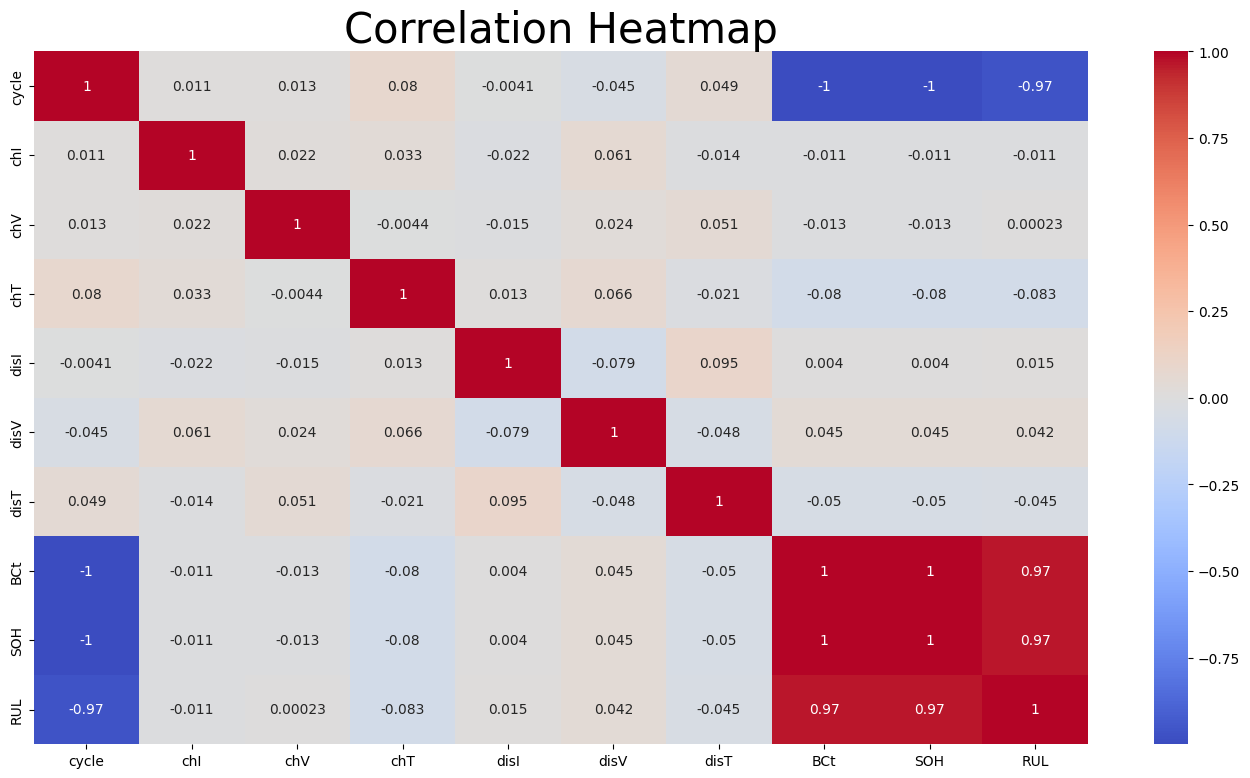

In [ ]:
# A basic correlation heatmap of the data
plt.figure(figsize=(17, 9))
sns.heatmap(data=df1.drop(columns='battery_id').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', size=(30))
plt.show()

In [ ]:
# Splitting the data into input and target variables
# RULs is our target variable in this case

x = df1.drop(columns=['battery_id', 'RUL', 'SOH'])
y = df1['RUL']
x.shape

(680, 8)

In [ ]:
# Splitting the data into train and test samples

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)

x_test_scaled = scaler.fit_transform(x_test)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)

In [ ]:
# Storing our models in a dict

models = {
    'linearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

In [ ]:
results = []
for name, model in models.items():
    model.fit(x_train_scaled_df, y_train)
    pred = model.predict(x_test_scaled_df)
    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, pred),
        "MSE": mean_squared_error(y_test, pred),
        "RMSE": root_mean_squared_error(y_test, pred),
        "R2": r2_score(y_test, pred)
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 476, number of used features: 8
[LightGBM] [Info] Start training from score 114.689076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
results_df = pd.DataFrame(results).sort_values(by='RMSE')
results_df

,Model,MAE,MSE,RMSE,R2
0,linearRegression,16.483487,293.202616,17.123160,0.928430
2,GradientBoosting,16.295119,325.549465,18.042989,0.920534
1,RandomForest,16.695294,341.036461,18.467173,0.916754
4,LightGBM,17.887753,407.937302,20.197458,0.900423
3,XGBoost,17.989944,430.050323,20.737656,0.895026


In [ ]:
# The best model which from our deductions predicted to be a linear model is linear regression

In [ ]:
!cp "/content/drive/My Drive/my drive/SOC & SOH of batteries/Experimental_data_aged_cell.csv" "/content/"
!cp "/content/drive/My Drive/my drive/SOC & SOH of batteries/Experimental_data_fresh_cell.csv" "/content/"

In [ ]:
df_aged = pd.read_csv('Experimental_data_aged_cell.csv')
df_fresh = pd.read_csv('Experimental_data_fresh_cell.csv')

In [ ]:
# Checking for basic information in our datase

print(f'aged data shape: {df_aged.shape}')
print(f'fresh data shape: {df_fresh.shape}')

aged data shape: (307513, 4)
fresh data shape: (358309, 4)


In [ ]:
# Checking for basic information in our datase

print(f'aged data info: {df_aged.info()}')
print(f'fresh data info: {df_fresh.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307513 entries, 0 to 307512
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         307513 non-null  float64
 1   Current      307513 non-null  float64
 2   Voltage      307513 non-null  float64
 3   Temperature  307513 non-null  float64
dtypes: float64(4)
memory usage: 9.4 MB
aged data info: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358309 entries, 0 to 358308
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         358309 non-null  float64
 1   Current      358309 non-null  float64
 2   Voltage      358309 non-null  float64
 3   Temperature  358309 non-null  float64
dtypes: float64(4)
memory usage: 10.9 MB
fresh data info: None


In [ ]:
print("Missing values in aged data:")
print(df_aged.isna().sum())
print("\nMissing values in fresh data:")
print(df_fresh.isna().sum())

Missing values in aged data:
Time           0
Current        0
Voltage        0
Temperature    0
dtype: int64

Missing values in fresh data:
Time           0
Current        0
Voltage        0
Temperature    0
dtype: int64


In [ ]:
print("Duplicated values in aged data:")
print(df_aged.duplicated().sum())
print("\nDuplicated values in fresh data:")
print(df_fresh.duplicated().sum())

Duplicated values in aged data:
0

Duplicated values in fresh data:
0


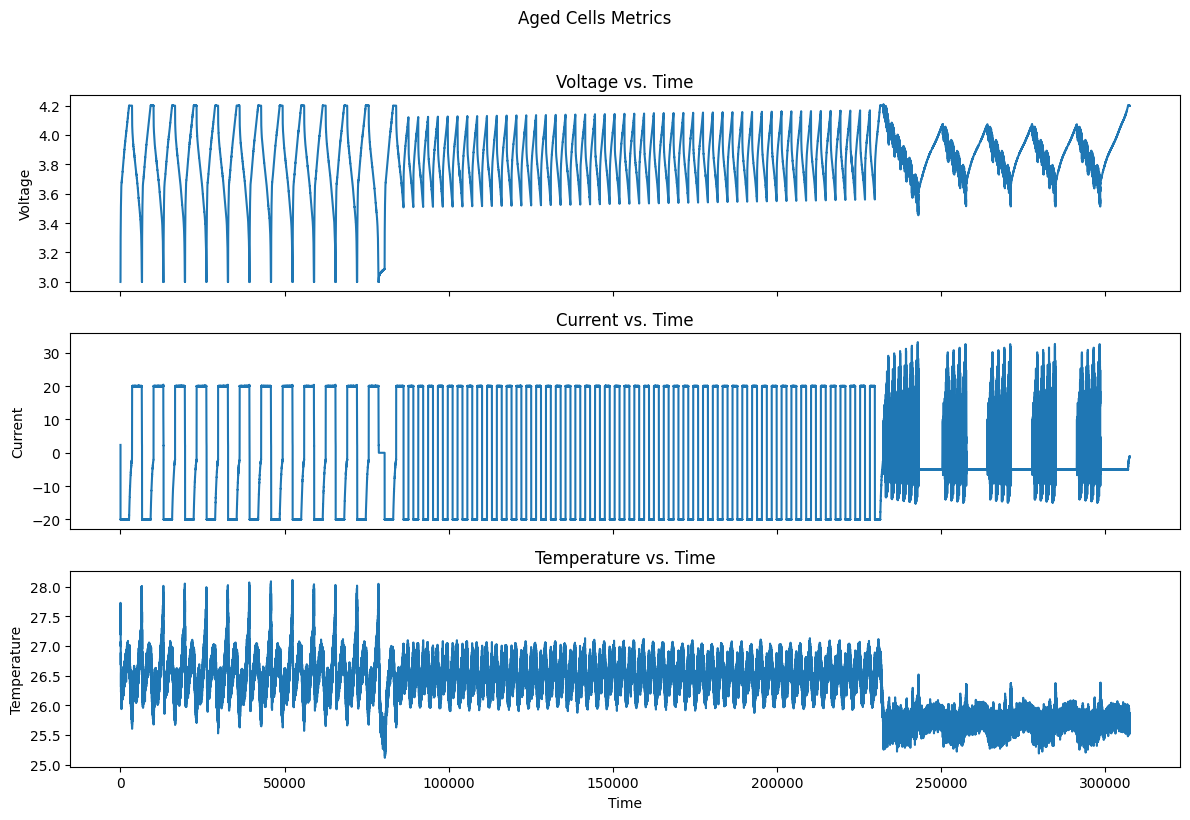

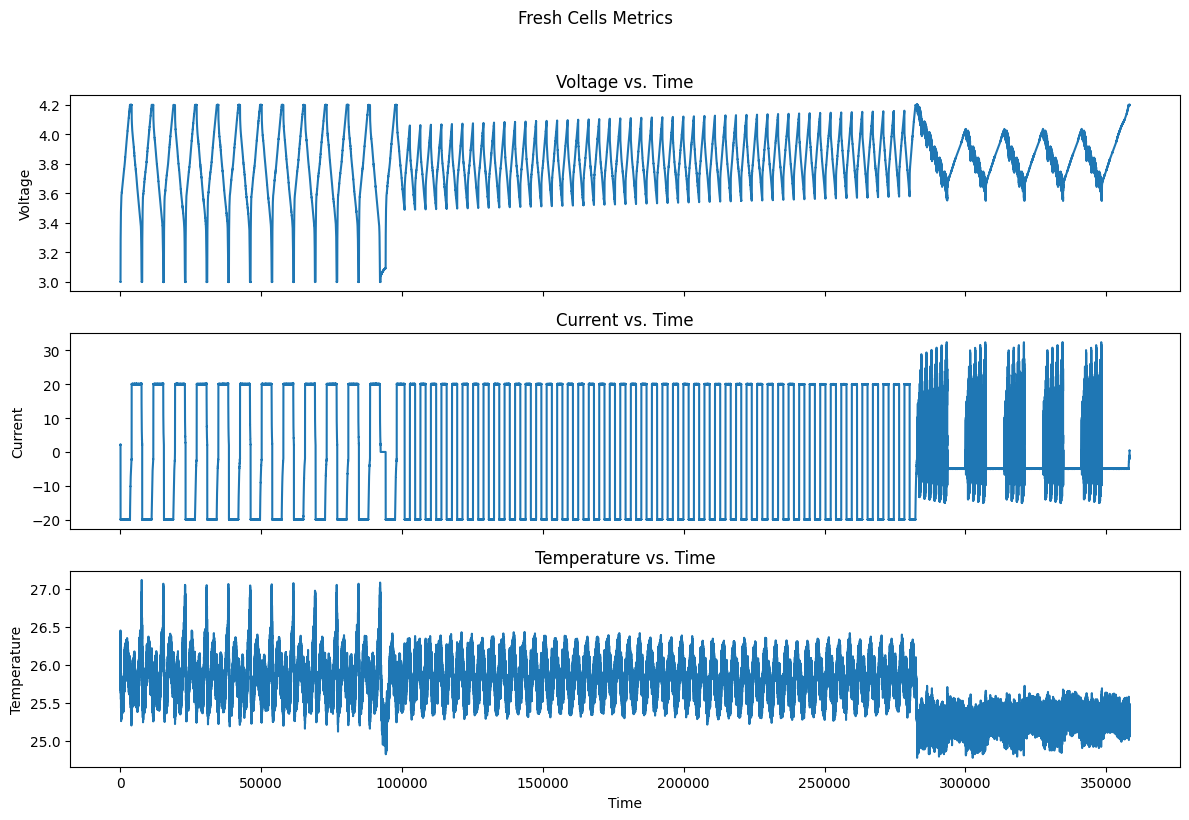

In [ ]:
# Starting off with a time series visualization

# Plotting voltage current and temperature over time for both experimental datas
def time_series_visualization(df, title):
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    metrics = ['Voltage', 'Current', 'Temperature']
    for i, metric in enumerate(metrics):
        sns.lineplot(x='Time', y=metric, data=df, ax=axes[i])
        axes[i].set_title(f"{metric} vs. Time")
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

time_series_visualization(df_aged, "Aged Cells Metrics")
time_series_visualization(df_fresh, "Fresh Cells Metrics")

In [ ]:
print("Aged Cells Stats:")
print(df_aged[['Voltage', 'Current', 'Temperature']].describe())
print("\nFresh Cells Stats:")
print(df_fresh[['Voltage', 'Current', 'Temperature']].describe())

Aged Cells Stats:
             Voltage        Current    Temperature
count  307513.000000  307513.000000  307513.000000
mean        3.849060      -0.163968      26.320183
std         0.206192      17.285349       0.433726
min         2.998059     -20.152779      25.112604
25%         3.726224     -19.996674      25.941347
50%         3.858586      -4.350225      26.372910
75%         3.996411      19.973799      26.640247
max         4.208818      33.203965      28.110600

Fresh Cells Stats:
             Voltage        Current    Temperature
count  358309.000000  358309.000000  358309.000000
mean        3.816629      -0.142882      25.715882
std         0.203309      17.736151       0.327616
min         2.998705     -20.105541      24.776148
25%         3.704146     -19.951117      25.491190
50%         3.820156      -4.340691      25.727844
75%         3.956430      20.037979      25.964499
max         4.204252      32.476771      27.113413


In [ ]:
def calculate_soc_and_energy(df, battery_type):
    df = df.copy()
    delta_t = df['Time'].diff().fillna(0)

    df['delta_charge'] = df['Current'] * delta_t
    df['cumulative_charge'] = df['delta_charge'].cumsum()

    max_charge = df['cumulative_charge'].max()
    min_charge = df['cumulative_charge'].min()
    df['SOC'] = 100 * (1 - (df['cumulative_charge'] - min_charge) / (max_charge - min_charge))

    df['Power'] = df['Voltage'] * df['Current']
    df['Energy'] = df['Power'] * delta_t / 3600
    df.drop(columns=['delta_charge', 'Power'], inplace=True)
    df['Battery_type'] = battery_type

    return df


df_aged_mod = calculate_soc_and_energy(df_aged, 'Aged')
df_fresh_mod = calculate_soc_and_energy(df_fresh, 'Fresh')



In [ ]:
df_aged_mod.head()

,Time,Current,Voltage,Temperature,cumulative_charge,SOC,Energy,Battery_type
0,0.000000,2.360728,2.999311,27.449894,0.000000,3.697737,0.000000,Aged
1,1.000008,2.303036,2.999813,27.724861,2.303054,3.694024,0.001919,Aged
2,2.000008,2.284371,2.999863,27.545357,4.587424,3.690342,0.001904,Aged
3,3.000008,2.221588,2.999863,27.457523,6.809013,3.686760,0.001851,Aged
4,4.000008,2.158805,2.999813,27.484249,8.967818,3.683280,0.001799,Aged


In [ ]:
df_fresh_mod.head()

,Time,Current,Voltage,Temperature,cumulative_charge,SOC,Energy,Battery_type
0,0.000000,2.158704,2.999607,26.384377,0.000000,7.213276,0.000000,Fresh
1,1.000000,2.287674,2.999407,26.227879,2.287674,7.210313,0.001906,Fresh
2,2.000000,2.228280,2.999757,26.449251,4.515954,7.207427,0.001857,Fresh
3,2.999992,2.224886,2.999857,26.277494,6.740822,7.204546,0.001854,Fresh
4,4.000000,2.134946,2.999958,26.380539,8.875785,7.201780,0.001779,Fresh


In [ ]:
df_merged = pd.concat([df_aged_mod, df_fresh_mod], ignore_index=True)

In [ ]:
df_merged

,Time,Current,Voltage,Temperature,cumulative_charge,SOC,Energy,Battery_type
0,0.000000,2.360728,2.999311,27.449894,0.000000,3.697737,0.000000,Aged
1,1.000008,2.303036,2.999813,27.724861,2.303054,3.694024,0.001919,Aged
2,2.000008,2.284371,2.999863,27.545357,4.587424,3.690342,0.001904,Aged
3,3.000008,2.221588,2.999863,27.457523,6.809013,3.686760,0.001851,Aged
4,4.000008,2.158805,2.999813,27.484249,8.967818,3.683280,0.001799,Aged
...,...,...,...,...,...,...,...,...
665817,358304.000008,-1.040085,4.199367,25.128578,-51195.872320,73.522401,-0.001213,Fresh
665818,358305.000000,-1.014630,4.199016,25.235462,-51196.886942,73.523715,-0.001183,Fresh
665819,358306.000000,-2.076933,4.202249,25.162935,-51198.963875,73.526405,-0.002424,Fresh
665820,358307.000000,0.510946,4.195336,25.209021,-51198.452929,73.525743,0.000595,Fresh


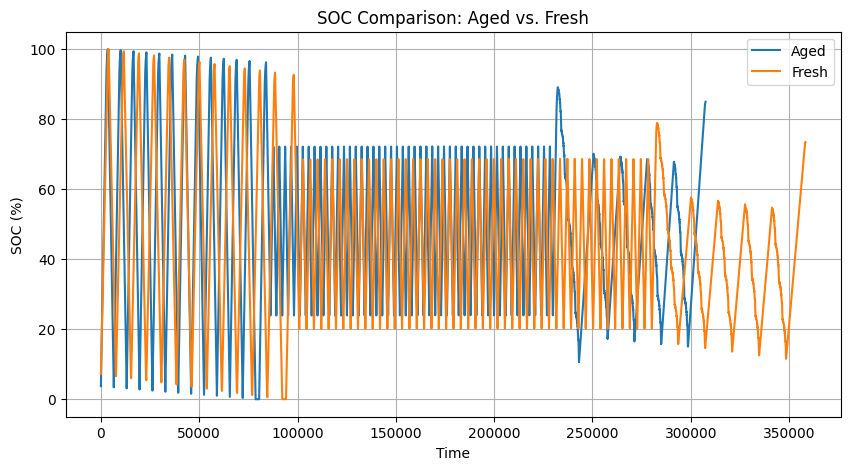

In [ ]:
plt.figure(figsize=(10, 5))
for label, group in df_merged.groupby('Battery_type'):
    plt.plot(group['Time'], group['SOC'], label=label)
plt.xlabel('Time')
plt.ylabel('SOC (%)')
plt.title('SOC Comparison: Aged vs. Fresh')
plt.legend()
plt.grid()
plt.show()

In [ ]:
df_merged = pd.get_dummies(df_merged, columns=['Battery_type'], dtype=int, drop_first=True)

In [ ]:
df_merged.head()

,Time,Current,Voltage,Temperature,cumulative_charge,SOC,Energy,Battery_type_Fresh
0,0.000000,2.360728,2.999311,27.449894,0.000000,3.697737,0.000000,0
1,1.000008,2.303036,2.999813,27.724861,2.303054,3.694024,0.001919,0
2,2.000008,2.284371,2.999863,27.545357,4.587424,3.690342,0.001904,0
3,3.000008,2.221588,2.999863,27.457523,6.809013,3.686760,0.001851,0
4,4.000008,2.158805,2.999813,27.484249,8.967818,3.683280,0.001799,0


In [ ]:
from sklearn.model_selection import train_test_split
input = df_merged.drop(columns=['SOC'])
target = df_merged['SOC']

X_train, X_test, Y_train, Y_test = train_test_split(input, target, test_size=0.3, random_state=42)

In [ ]:
results1 = []
for name, model in models.items():
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    results1.append({
        "Model": name,
        "MAE": mean_absolute_error(Y_test, preds),
        "MSE": mean_squared_error(Y_test, preds),
        "RMSE": root_mean_squared_error(Y_test, preds),
        "R2": r2_score(Y_test, preds)
    })

In [ ]:
results1_df = pd.DataFrame(results1).sort_values(by='RMSE')
results1_df

,Model,MAE,MSE,RMSE,R2
1,RandomForest,0.000532,0.000238,0.015412,0.999999
3,XGBoost,0.097360,0.018930,0.137585,0.999955
4,LightGBM,0.107043,0.024242,0.155699,0.999942
2,GradientBoosting,0.279261,0.140793,0.375224,0.999665
0,linearRegression,1.709548,4.639457,2.153940,0.988946


In [ ]:
!cp "/content/drive/My Drive/my drive/SOC & SOH of batteries/OCV_vs_SOC_curve.csv" "/content/"

/tmp/ipython-input-54-3405104424.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


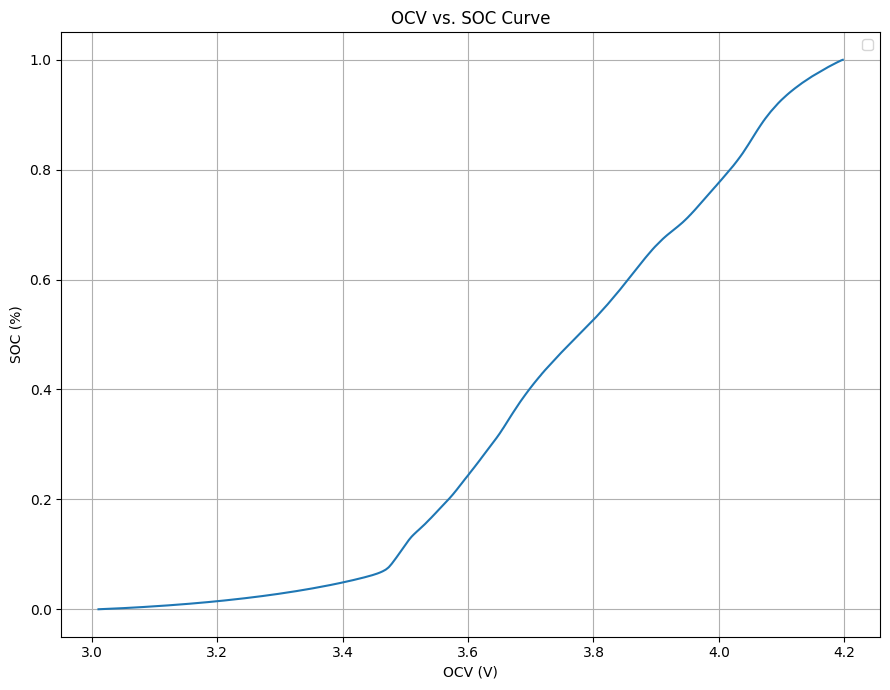

In [ ]:
df_ocv = pd.read_csv('OCV_vs_SOC_curve.csv')

plt.figure(figsize=(9, 7))
sns.lineplot(x='V0', y='SOC', data=df_ocv)
plt.title('OCV vs. SOC Curve')
plt.xlabel('OCV (V)')
plt.ylabel('SOC (%)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# The OCV of a battery (Open Circuit Voltage) as the name implies is the voltage of a battery when current is not flowing through it
# In Batteries, estimating the soc directly is nearly imposssible, therefore soc is calculated as a function of the ocv
# For Aged batteries, the shape of the OCV–SoC curve can change slightly or significantly and this can be used to detect deghredation in batteries.